# 3F8 Binary Classifier 

This notebook is my implementation of the 3F8 coursework. A few of the plotting functions are adapted versions of those provided in the supplementary code.


## The Data ##

We start by importing the required modules as well as the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as skms
import sklearn.metrics as skme

In [2]:
X = np.loadtxt('X.txt')
Y = np.loadtxt('Y.txt')

In [3]:
X.shape

(1000, 2)

In [4]:
Y.shape

(1000,)

The data consist of 1000 2D data points, X, and 1000 associated labels, Y.

In [5]:
np.unique(Y)

array([0., 1.])

As expected, the data is binary, i.e. there are two classes.

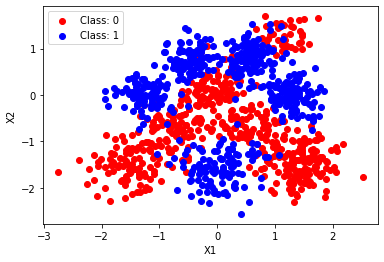

In [6]:
def plot_classes_2D(x, y, c):
    """
        Produces a labelled scatter plot of 2D data
        
        Inputs: X - an (Nx2) array of datapoints
                Y - a length N array of associated labels
                c - a length 2 array of matplotlib colour codes
                
        Outputs: None
    """
    ax = plt.gca()
    for index, label in enumerate(np.unique(y)):
        x1 = [x[i,0] for i in range(x.shape[0]) if y[i] == label]
        x2 = [x[j,1] for j in range(x.shape[0]) if y[j] == label]
        ax.scatter(x1, x2, c=colours[index], label='Class: '+str(int(label)))
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

colours = ['r', 'b']
plot_classes_2D(X, Y, colours)

The data clearly has a very non-linear decision boundary, and so a logistic regression using only the linear input data is unlikely to perform well.

## Training a basic logistic model ##
First we define some useful functions for the training

In [7]:
def logistic(z):
    """
        Sigmoid function
        
        Inputs: z - a numerical input to the function
        Output: sigmoid
    """
    return 1. / (1. + np.exp(-1*z))

def create_X_tilde(x):
    """
        Prepends a column of 1's to the array X
        
        Inputs: x - array of 2D data to form x_tilde
        Output: x_tilde
    """
    ones = np.ones((x.shape[0], 1))
    return np.concatenate((ones, x), axis=1)

def calc_grad(beta, x, y):
    """
    Computes the numerical expression derived elsewhere for the grad of the log-likelihood

    Inputs: beta - current weight values
            x - x_tilde, i.e. data array x with column of 1's prepended
            y - class labels for x
    Output: Grad
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(x.T, (np.multiply(y, 1-sigmas) - np.multiply(1-y, sigmas)))

def calc_likelihood(beta, x, y):
    """
        Computes the numerical expression derived elsewhere for the log-likelihood
        
        Inputs: beta - current weight values
                x - x_tilde, i.e. data array x with column of 1's prepended
                y - class labels for x
        Output: log-likelihood
    """
    dot_prod = np.matmul(x, beta)
    sigmas = logistic(dot_prod)
    return np.dot(y.T, sigmas) + np.dot((1-y).T, (1-sigmas).T)

We use scikitlearn to randomly split the data for testing purposes

In [8]:
X_train, X_test, Y_train, Y_test = skms.train_test_split(X, Y, train_size=0.8)
X_tilde_train = create_X_tilde(X_train)
X_tilde_test = create_X_tilde(X_test)

The basic process for training our beta is gradient ascent. We update beta after each iteration to be it's old value plus the scaled grad at that location

In [9]:
learning_rate = 0.0001
steps = 500
def train_model(x_tilde_train, y_train, x_tilde_test, y_test, alpha, n):
    beta = np.random.normal(size=x_tilde_train.shape[1])
    lls_train = np.ones(n)
    lls_test = np.ones(n)
    for i in range(n):
        beta = beta + alpha * calc_grad(beta, x_tilde_train, y_train)
        ll_train = calc_likelihood(beta, x_tilde_train, y_train)/X_tilde_train.shape[0]
        lls_train[i] = ll_train
        ll_test = calc_likelihood(beta, x_tilde_test, y_test)/X_tilde_test.shape[0]
        lls_test[i] = ll_test
    return beta, lls_train, lls_test

def plot_likelihoods(ll_train, ll_test, n):
    axis = np.arange(n)
    plt.plot(axis, ll_train, label='Train')
    plt.plot(axis, ll_test, label='Test')
    plt.xlabel('Iterations')
    plt.ylabel('Average log-likelihood')
    plt.legend(loc='right')

The choice of learning_rate and steps have largely been trial and error. If the learning rate is too small then beta never converges, if it is too large then it tends to oscillate.
Additionally if we choose to use too many steps then beta tends to grow unbouded. This is because in each iteration we add a very small term to beta (which will be non-zero when our choice of learning rate is not good enough). A possible improvement to this is to add a regularisation term to the log-likelihood

In [10]:
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)


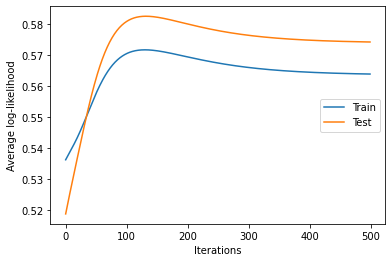

In [11]:
plot_likelihoods(likelihoods_train, likelihoods_test, steps)

In [12]:
likelihoods_train[-1]

0.5638309612699782

In [13]:
likelihoods_test[-1]

0.574150054679498

The log-likelihood converges well.

In [14]:
betas

array([ 0.37168378, -0.08342746,  0.7782372 ])

In [15]:
def plot_predictive_distribution(x, y, betas, map_inputs = lambda x : x):
    plot_classes_2D(x, y, colours)
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    ax = plt.gca()
    new_x_tilde = create_X_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = logistic(np.dot(new_x_tilde, betas))
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

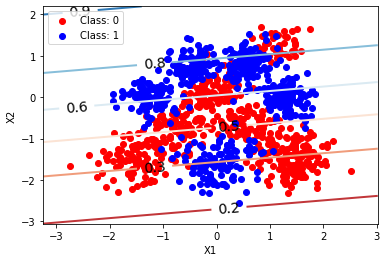

In [16]:
plot_predictive_distribution(X, Y, betas)

The logistic regression performs moderately. It is unable to properly explain the lower class 1 group and so seems to ignore it.

In [17]:
def predict(X_tilde, beta):
    return logistic(np.dot(X_tilde, beta))

def decision(probs):
    return np.array([prob>0.5 for prob in probs]).astype(int)

In [18]:
predictions = predict(create_X_tilde(X_test), betas)
decisions = decision(predictions)

In [19]:
def confusion_matrix(y_true, y_pred):
    return skme.confusion_matrix(y_true, y_pred)

In [20]:
confusion_matrix(Y_test, decisions)/Y_test.shape

array([[0.41 , 0.165],
       [0.09 , 0.335]])

## Radial Basis Functions ##

In [21]:
def evaluate_basis_functions(l, X, Z):
        X_sq = np.sum(X**2, 1) # length N array of sum of squares of each row
        Z_sq = np.sum(Z**2, 1)
        ones_X = np.ones(X.shape[0])
        ones_Z = np.ones(Z.shape[0])

        distance = np.outer(X_sq, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z_sq)
        return np.exp(-(0.5 / l**2) * distance)

def metrics(lls_train, lls_test, beta, n, x, x_train, x_test, y, y_test, l):
    plot_likelihoods(lls_train, lls_test, n)
    plt.show()
    plot_predictive_distribution(x, y, beta, lambda x : evaluate_basis_functions(l, x, x_train))
    plt.show()
    decisions = decision(predict(create_X_tilde(evaluate_basis_functions(l, x_test, x_train)), beta))
    print(confusion_matrix(y_test, decisions)/y_test.shape)

el = 0.01

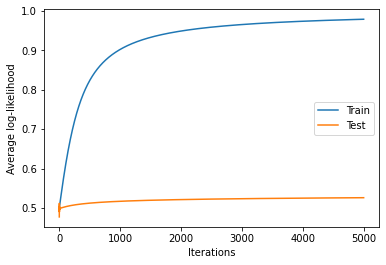

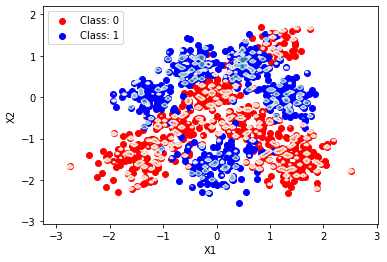

[[0.56  0.015]
 [0.285 0.14 ]]


In [22]:
l = 0.01
learning_rate = 0.01
steps = 5000
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

In [23]:
print(likelihoods_train[-1], likelihoods_test[-1])

0.979221363163504 0.5261803916192298


With l=0.01, the length scale for the Gaussian RBF is arguably too small. The model is fitting to individual data points and cannot caputre the behaviour of the classes as a whole. Strangely, the model produces a significant amount of false negatives.

el = 0.1

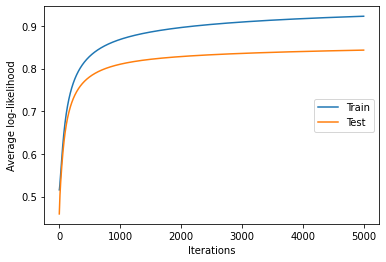

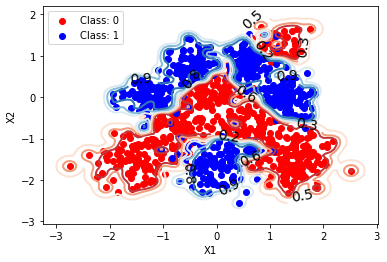

[[0.51  0.065]
 [0.045 0.38 ]]


In [24]:
l = 0.1
learning_rate = 0.001
steps = 5000
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

In [25]:
print(likelihoods_train[-1], likelihoods_test[-1])

0.9223833091174263 0.8430598557863349


l=0.1 seems to be a better length scale. The contours encircle clusters of points, rather than individual points. The model does, however, still seem to overfit the training data, likely due to the lack of regularisation. The confusion matrix shows that roughly 87.5% of test points were correctly labelled.

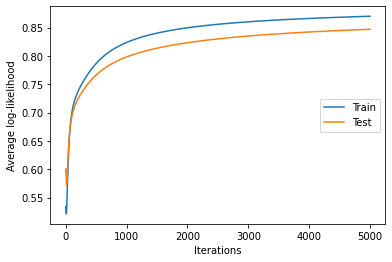

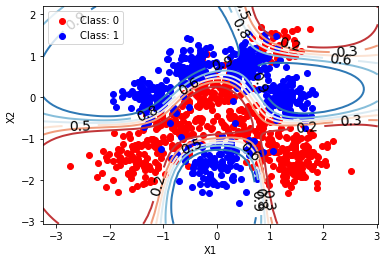

[[0.515 0.06 ]
 [0.045 0.38 ]]


In [26]:
l = 1
learning_rate = 0.0001
steps = 5000
X_tilde_train = create_X_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = create_X_tilde(evaluate_basis_functions(l, X_test, X_train))
betas, likelihoods_train, likelihoods_test = train_model(X_tilde_train, Y_train, X_tilde_test, Y_test, learning_rate, steps)
metrics(likelihoods_train, likelihoods_test, betas, steps, X, X_train, X_test, Y, Y_test, l)

In [27]:
print(likelihoods_train[-1], likelihoods_test[-1])

0.8699662551838009 0.8469727132080962


This time, the length scale (l=1) is about right. The probability contours follow the heuristic boundaries nicely, the train and test likelihoods seems quite close and the confusion matrix shows the classifier is ~90% accurate. Additionally, it segments the space a bit better than the previous model, meaning we might expect it to perform better on unseen data.

# FTR
This section will delve slightly deeper and explore bayesian logistic regression. We will start by studying the laplace approximation.

As a sanity check we make sure our data has not been edited by the previous section

In [106]:
print(X.shape, Y.shape)

(1000, 2) (1000,)


In order to incorporate our Gaussian prior on the weights we need to define some new functions. Helpfully, our log posterior values/gradients are almost the same as they were in the previous section, except for the prior term which we can treat seperately.

In [107]:
def calc_posterior(beta, x_tilde, y, var_prior):
    """
        Computes the numerical expression derived elsewhere for the posterior probability
        
        Inputs: beta - current weight values
                x - x_tilde, i.e. data array x with column of 1's prepended
                y - class labels for x
                var_prior - prior on the variance values for weights
        Output: posterior probability
    """
    dot_prod = np.matmul(x_tilde, beta)
    sigmas = logistic(dot_prod)
    log_likelihood_data = np.dot(y.T, sigmas) + np.dot((1-y).T, (1-sigmas).T)
    
    N = beta.shape[0]
    Var = var_prior*np.eye(N, N)
    prior_term = -0.5 * beta.T.dot(np.linalg.inv(Var)).dot(beta)
    
    return log_likelihood_data + prior_term

def minus_calc_posterior(beta, x_tilde, y, var_prior):
    return -1*calc_posterior(beta, x_tilde, y, var_prior)

def posterior_grad(beta, x_tilde, y, var_prior):
    
    dot_prod = np.matmul(x_tilde, beta)
    sigmas = logistic(dot_prod)
    log_likelihood_grad = np.dot(x_tilde.T, (np.multiply(y, 1-sigmas) - np.multiply(1-y, sigmas)))
    
    N = beta.shape[0]
    Var = var_prior*np.eye(N, N)
    prior_term = -1 * np.linalg.inv(Var).dot(beta)
    
    return log_likelihood_grad + prior_term

def minus_posterior_grad(beta, x_tilde, y, var_prior):
    return -1*posterior_grad(beta, x_tilde, y, var_prior)

In [108]:
from scipy.optimize import fmin_l_bfgs_b

Once we have our posterior (gradient), we can minimise the negative posterior using standard libraries. For the Laplace appriximation we are interested in the value of $\beta^{MAP}$, not the actual function value, so we can just extract this from the optimisation's output.

In [109]:
def get_beta_map(x_tilde, y, var_prior):
    beta_guess = np.random.normal(size=x_tilde.shape[1])
    return fmin_l_bfgs_b(minus_calc_posterior, x0=beta_guess, args=(x_tilde, y, var_prior), fprime=minus_posterior_grad)

In [110]:
X_tilde = create_X_tilde(X)
beta_map = get_beta_map(X_tilde, Y, 1)[0]

In [140]:
beta_map

array([0.28997672, 0.38698733, 0.9974832 ])

These beta correspond to the minimum of the negative posterior, or equivalently the maximum of the posterior distribution.

In [197]:
def calc_inv_log_Hessian(beta, x_tilde, var_prior):
    N = beta.shape[0]
    Var = var_prior*np.eye(N, N)
    dot_prod = np.matmul(x_tilde, beta)
    scalar_term = logistic(dot_prod)*(1-logistic(dot_prod))
    outer_term = np.dot(x_tilde.T, x_tilde)
    term = np.array([(scalar * outer_term) for scalar in scalar_term]) # is there a better way to do this?
    return np.sum(term, axis=0) + np.linalg.inv(Var)

In [198]:
cov_matrix = np.linalg.inv(calc_inv_log_Hessian(beta_map, X_tilde, 1))
cov_matrix

array([[ 6.00218875e-06, -6.79475381e-07,  2.16400941e-06],
       [-6.79475381e-07,  4.71127462e-06, -2.37816064e-07],
       [ 2.16400941e-06, -2.37816064e-07,  5.20450509e-06]])

Having checked that the output is roughly what we would expect for the standard case, let us try extending the data as we did before with radial basis functions.

In [204]:
l = 0.1
var_prior=1
X_tilde_rbf = create_X_tilde(evaluate_basis_functions(l, X, X))

In [210]:
beta_map_rbf = get_beta_map(X_tilde_rbf, Y, var_prior)[0]

In [220]:
inv_cov_matrix_rbf = calc_inv_log_Hessian(beta_map_rbf, X_tilde_rbf, 1)

Our new weights are:

In [216]:
beta_map_rbf

array([-0.31687586, -0.39725372, -0.22729452, ..., -0.35897193,
       -0.05303816,  0.27891348])

And our Covariance matrix is:

In [221]:
np.linalg.inv(cov_matrix_rbf)

array([[ 1.05714028e+05,  7.69250682e+02,  5.55490018e+02, ...,
         8.83289402e+02,  7.29261779e+02,  4.00064072e+02],
       [ 7.69250682e+02,  3.31299032e+02, -3.28097806e-12, ...,
        -5.20667444e-12,  6.67009066e+01,  8.23895372e-06],
       [ 5.55490018e+02, -4.43788715e-12,  3.75644162e+02, ...,
        -1.59415469e-13, -2.99971191e-12, -1.22465013e-12],
       ...,
       [ 8.83289402e+02, -7.69710320e-12, -2.78262808e-12, ...,
         4.95139985e+02, -5.85884780e-12, -1.54318805e-12],
       [ 7.29261779e+02,  6.67009066e+01, -2.33224573e-12, ...,
        -2.99047500e-12,  4.11365828e+02,  3.81189117e-11],
       [ 4.00064072e+02,  8.23894772e-06, -1.56724536e-12, ...,
        -4.15608061e-12,  3.74436635e-11,  2.25993427e+02]])